In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 28 15:47:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:84:00.0 Off |                  N/A |
| 24%   36C    P8             23W /  250W |   10494MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
torch.cuda.empty_cache()

In [4]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)

channels = 3 # number of image channels (gray scale)
img_size = 32 # size of each image dimension
img_dim = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))
latent_dim = 100

# Hyperparameters

glr = 2e-4
dlr= 2e-4

NUM_EPOCHS = 100
BATCH_SIZE = 64

logging_interval = 200
# save_model = True

cuda:2


In [5]:
trf = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.CIFAR10(root='data',
                               train=True,
                               transform=trf,
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 170498071/170498071 [00:29<00:00, 5739086.80it/s]


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


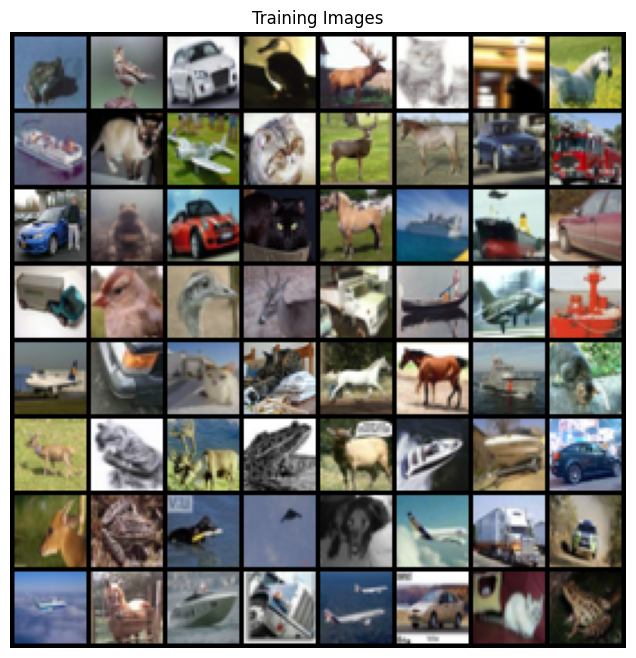

In [6]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images[:64],
                        padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

In [7]:
class Generator(nn.Module):
  def __init__(self, latent_dim = 100, img_dim=(1,28,28)):
    super(Generator, self).__init__()
    self.latent_dim = latent_dim
    self.img_dim = img_dim

    def block(in_feat, out_feat, normalize=True, dropout=True):
      layers = [nn.Linear(in_feat, out_feat)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      if dropout:
        layers.append(nn.Dropout(p=0.5))
      return layers

    self.model = nn.Sequential(
        *block(self.latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        nn.Linear(512, int(np.prod(img_dim))),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *self.img_dim)
    return img

In [8]:
class Discriminator(nn.Module):
  def __init__(self, img_dim=(1,28,28)):
    super(Discriminator, self).__init__()
    self.img_dim = img_dim

    self.model = nn.Sequential(
        nn.Linear(int(np.prod(self.img_dim)), 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )

  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    validity = self.model(img_flat)

    return validity

In [9]:
gen = Generator(latent_dim, img_dim)
dis = Discriminator(img_dim)

In [10]:
gen

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=512, out_features=3072, bias=True)
    (12): Tanh()
  )
)

In [11]:
dis

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [12]:
gen.to(device)
next(gen.parameters()).is_cuda

True

In [13]:
dis.to(device)
next(dis.parameters()).is_cuda

True

In [14]:
# Total num. of parametes
num_params = sum(p.numel() for p in gen.parameters())
# Total num. of "trainable" parameters
num_trainable_params = sum(p.numel() for p in gen.parameters() if p.requires_grad)
print(f'Total num. of parametes: {num_params}')
print(f'Total num. of Trainable parametes: {num_trainable_params}')

Total num. of parametes: 1755008
Total num. of Trainable parametes: 1755008


In [15]:
# Total num. of parametes
num_params = sum(p.numel() for p in dis.parameters())
# Total num. of "trainable" parameters
num_trainable_params = sum(p.numel() for p in dis.parameters() if p.requires_grad)
print(f'Total num. of parametes: {num_params}')
print(f'Total num. of Trainable parametes: {num_trainable_params}')

Total num. of parametes: 1704961
Total num. of Trainable parametes: 1704961


In [16]:
adversarial_loss = torch.nn.BCELoss()

In [17]:
optimizer_G = torch.optim.Adam(gen.parameters(), lr=glr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=dlr, betas=(0.5, 0.999))

In [18]:
log_dict = {'train_generator_loss_per_batch': [],
              'train_discriminator_loss_per_batch': [],
              'train_discriminator_real_acc_per_batch': [],
              'train_discriminator_fake_acc_per_batch': [],
              'images_from_noise_per_epoch': []}
# Batch of latent (noise) vectors for
# evaluating / visualizing the training progress
# of the generator
fixed_z = torch.randn(64, latent_dim, device=device) # format NCHW

start_time = time.time()
for epoch in range(NUM_EPOCHS):

  gen.train()
  dis.train()
  for batch_idx, (features, _) in enumerate(train_loader):

    batch_size = features.size(0)

    # real images
    real_images = features.to(device)
    real_labels = torch.ones(batch_size, device=device) # real label = 1

    # generated (fake) images
    z = torch.randn(batch_size, latent_dim, device=device)  # format NCHW
    fake_images = gen(z)
    fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
    flipped_fake_labels = real_labels # here, fake label = 1
    flipped_fake_labels.to(device)


    # --------------------------
    # Train Discriminator
    # --------------------------

    optimizer_D.zero_grad()

    # get discriminator loss on real images
    discr_pred_real = dis(real_images).view(-1) # Nx1 -> N
    real_loss = adversarial_loss(discr_pred_real, real_labels)

    # get discriminator loss on fake images
    discr_pred_fake = dis(fake_images.detach()).view(-1)
    fake_loss = adversarial_loss(discr_pred_fake, fake_labels)

    # combined loss
    discr_loss = 0.5*(real_loss + fake_loss)

    discr_loss.backward()
    optimizer_D.step()

    # --------------------------
    # Train Generator
    # --------------------------

    optimizer_G.zero_grad()

    # get discriminator loss on fake images with flipped labels
    discr_pred_fake = dis(fake_images).view(-1)
    gener_loss = adversarial_loss(discr_pred_fake, flipped_fake_labels)
    gener_loss.backward()

    optimizer_G.step()

    # --------------------------
    # Logging
    # --------------------------
    log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
    log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

    predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
    predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
    acc_real = (predicted_labels_real == real_labels).float().mean()*100.
    acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
    log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
    log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

    if not batch_idx % logging_interval:
      print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
              % (epoch+1, NUM_EPOCHS, batch_idx,
                len(train_loader), gener_loss.item(), discr_loss.item()))

  ### Save images for evaluation
  with torch.no_grad():
    fake_images = gen(fixed_z).detach().cpu()
    log_dict['images_from_noise_per_epoch'].append(make_grid(fake_images,
                                                              padding=2,
                                                              normalize=True))
  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

# if save_model:
#   torch.save({
#           'model_state_dict': gen.state_dict(),
#           'optimizer_state_dict': optimizer_G.state_dict()
#           }, 'ganGen_mnist.pt')

#   torch.save({
#           'model_state_dict': dis.state_dict(),
#           'optimizer_state_dict': optimizer_D.state_dict()
#           }, 'ganDis_mnist.pt')



Epoch: 001/100 | Batch 000/782 | Gen/Dis Loss: 0.7223/0.6932
Epoch: 001/100 | Batch 200/782 | Gen/Dis Loss: 1.9041/0.1572
Epoch: 001/100 | Batch 400/782 | Gen/Dis Loss: 3.8980/0.2717
Epoch: 001/100 | Batch 600/782 | Gen/Dis Loss: 3.2044/0.2592
Time elapsed: 0.33 min
Epoch: 002/100 | Batch 000/782 | Gen/Dis Loss: 2.7566/0.4121
Epoch: 002/100 | Batch 200/782 | Gen/Dis Loss: 2.5224/0.2399
Epoch: 002/100 | Batch 400/782 | Gen/Dis Loss: 2.4158/0.3125
Epoch: 002/100 | Batch 600/782 | Gen/Dis Loss: 2.9055/0.3503
Time elapsed: 0.66 min
Epoch: 003/100 | Batch 000/782 | Gen/Dis Loss: 2.2744/0.3199
Epoch: 003/100 | Batch 200/782 | Gen/Dis Loss: 1.7066/0.4079
Epoch: 003/100 | Batch 400/782 | Gen/Dis Loss: 1.5715/0.5219
Epoch: 003/100 | Batch 600/782 | Gen/Dis Loss: 1.8019/0.4346
Time elapsed: 0.98 min
Epoch: 004/100 | Batch 000/782 | Gen/Dis Loss: 1.5288/0.4881
Epoch: 004/100 | Batch 200/782 | Gen/Dis Loss: 1.7700/0.5108
Epoch: 004/100 | Batch 400/782 | Gen/Dis Loss: 1.6444/0.3995
Epoch: 004/100 |

KeyboardInterrupt: 

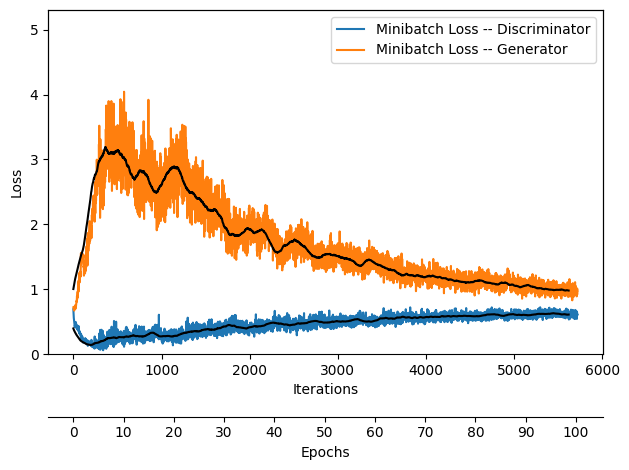

In [19]:
losses_list=(log_dict['train_discriminator_loss_per_batch'],
            log_dict['train_generator_loss_per_batch'])
custom_labels_list=(' -- Discriminator', ' -- Generator')
averaging_iterations = 100

for i,_ in enumerate(losses_list):
    if not len(losses_list[i]) == len(losses_list[0]):
        raise ValueError('All loss tensors need to have the same number of elements.')

if custom_labels_list is None:
    custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

iter_per_epoch = len(losses_list[0]) // NUM_EPOCHS

plt.figure()
ax1 = plt.subplot(1, 1, 1)

for i, minibatch_loss_tensor in enumerate(losses_list):
    ax1.plot(range(len(minibatch_loss_tensor)),
              (minibatch_loss_tensor),
              label=f'Minibatch Loss{custom_labels_list[i]}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_tensor,
                          np.ones(averaging_iterations,)/averaging_iterations,
                          mode='valid'),
              color='black')

if len(losses_list[0]) < 1000:
    num_losses = len(losses_list[0]) // 2
else:
    num_losses = 1000
maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
ax1.set_ylim([0, np.max(maxes)*1.5])
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))

newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticks(newpos[::10])
ax2.set_xticklabels(newlabel[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.tight_layout()

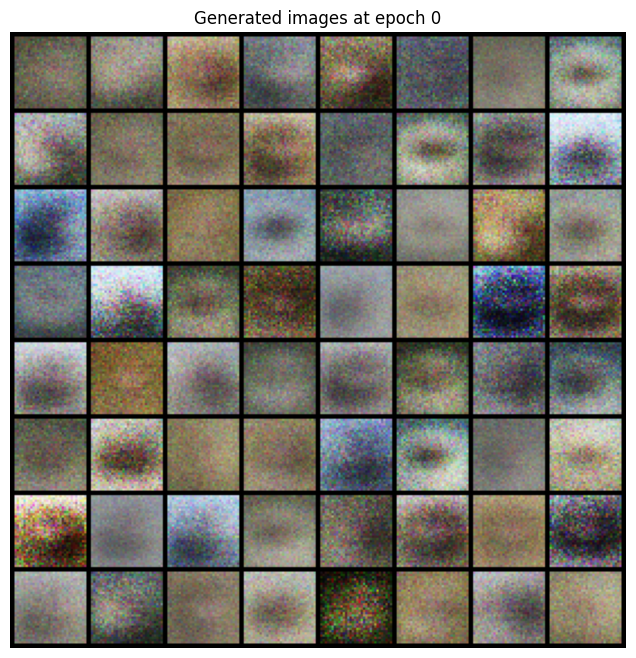

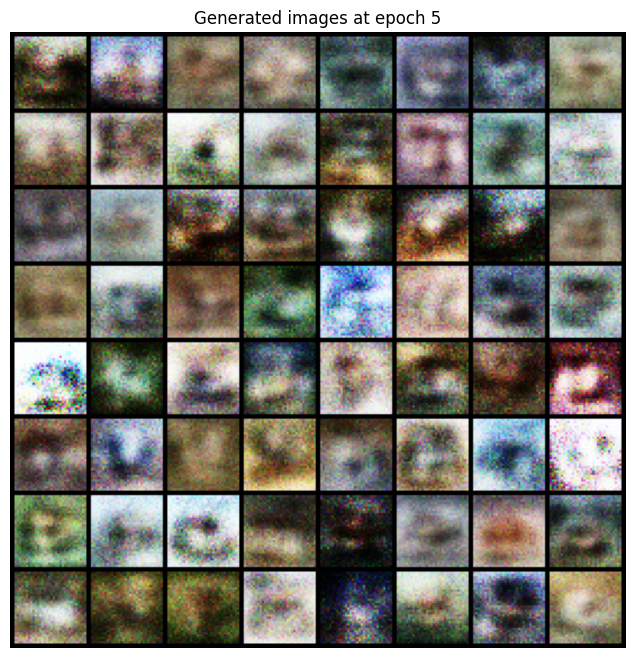

IndexError: list index out of range

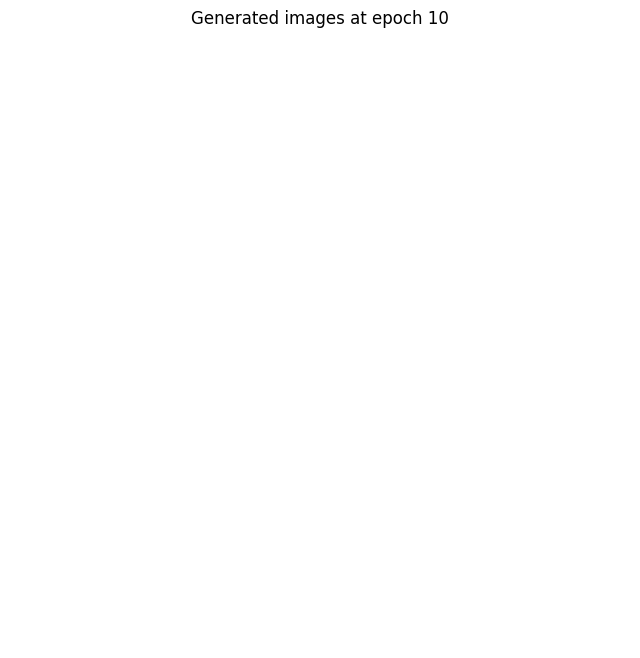

In [20]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.title(f'Generated images at epoch {i}')
  plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
  plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()